# House Prices Prediction
Author - Rishabh Jain

In [1]:
import warnings, os, math
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np 
import pandas as pd 
import seaborn as sns
from scipy.stats import norm

In [2]:
train=pd.read_csv('data/train.csv')
test=pd.read_csv('data/test.csv')
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
recordId='Id'
target='SalePrice'
trainId=train[recordId]
testId=test[recordId]

# Dropping "Id" column from train and test set
train.drop(recordId,axis=1,inplace=True)
test.drop(recordId,axis=1,inplace=True)

# Checking Dataset shape
print('Train Set\t %d X %d'%(train.shape[0],train.shape[1]))
print('Test Set\t %d X %d'%(test.shape[0],test.shape[1]))

Train Set	 1460 X 80
Test Set	 1459 X 79


## Data Preprocessing

### Outliers

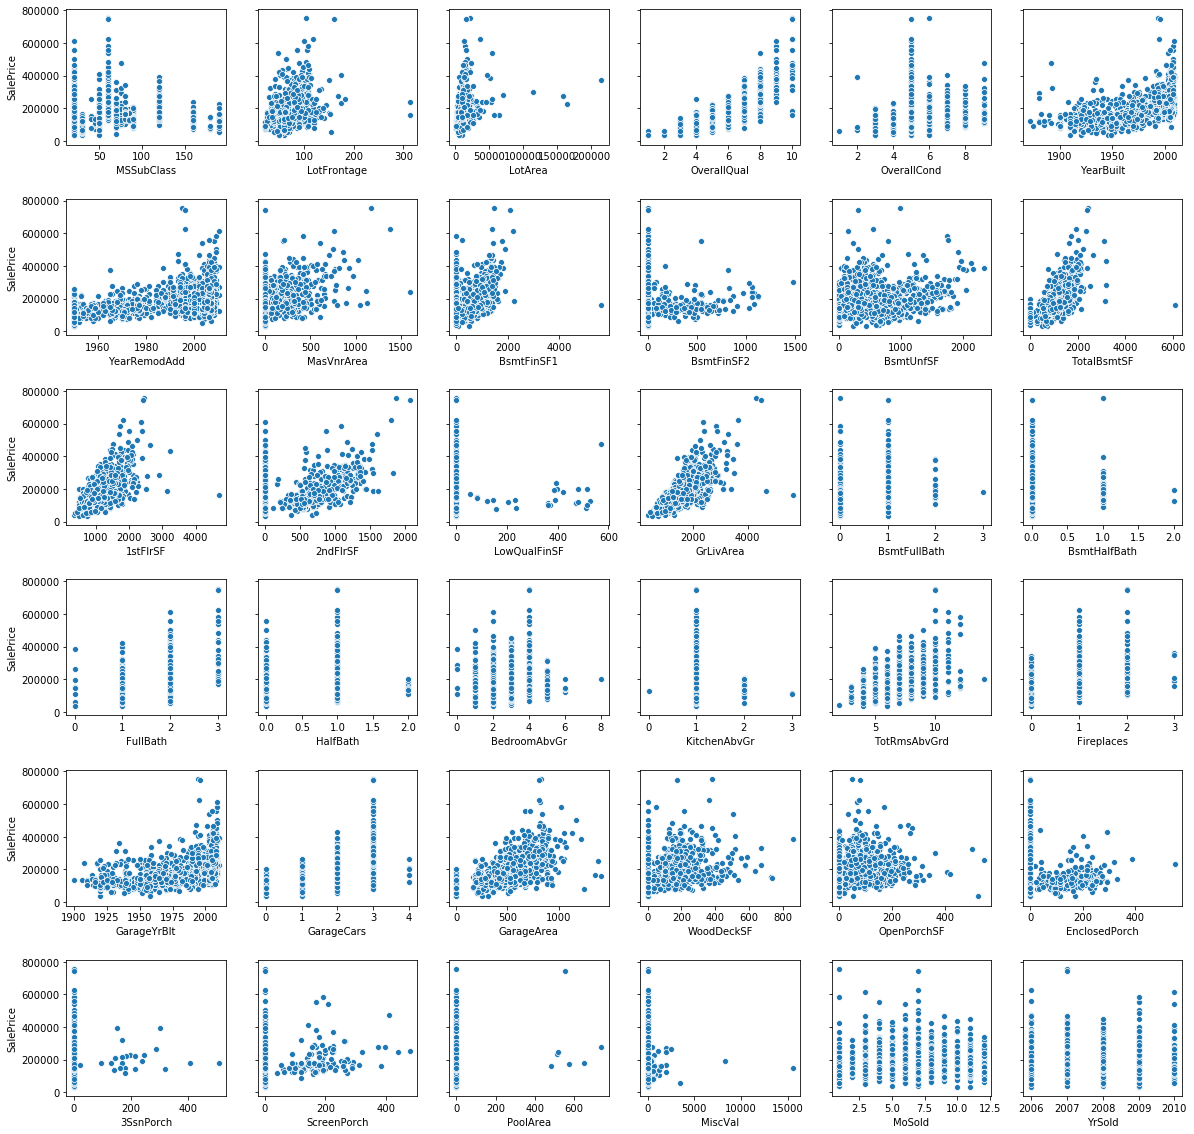

In [4]:
numericalFeatures=train.select_dtypes(include=[np.number]).columns
nrows=6
ncols=int(len(numericalFeatures)/nrows)
fig,ax=plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,20),sharey=True)
fig.subplots_adjust(wspace=0.2,hspace=0.4)
for row in range(nrows):
    for col in range(ncols):
        sns.scatterplot(train[numericalFeatures[row*ncols+col]],train[target],ax=ax[row,col])

In [5]:
# Scatter plot of 'LotFrontage' VS 'SalePrice' has two outliers to the right. Therefore we can delete them.
train.drop(index=train['LotFrontage'].sort_values(ascending=False)[:2].index,inplace=True)
print('Train Set\t %d X %d'%(train.shape[0],train.shape[1]))

Train Set	 1458 X 80


### Note : 
There are other outliers too in the training data. However removing all of them will effect our model badly, if there are outliers in test data as well. Hence, we will just manage to make models robust with them.

#### Let's first concatenate the train and test set for handling missing data and feature engineering

In [6]:
nTrain=train.shape[0]
nTest=test.shape[0]
trainY=train[target]
allData=pd.concat((train,test)).reset_index(drop=True)
allData.drop(target,axis=1,inplace=True)
print('Train + Test Set\t %d X %d'%(allData.shape[0],allData.shape[1]))

Train + Test Set	 2917 X 79


### Missing Data

,Count,Percentage,Type
PoolQC,2908,99.691464,object
MiscFeature,2812,96.400411,object
Alley,2719,93.212204,object
Fence,2346,80.425094,object
FireplaceQu,1420,48.680151,object
LotFrontage,486,16.660953,float64
GarageCond,159,5.450806,object
GarageQual,159,5.450806,object
GarageYrBlt,159,5.450806,float64
GarageFinish,159,5.450806,object


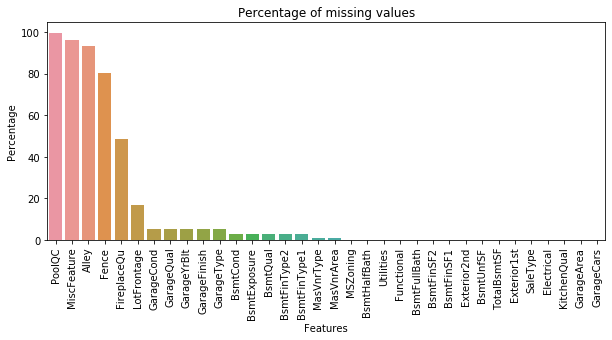

In [7]:
count=allData.isnull().sum().sort_values(ascending=False)
percentage=(allData.isnull().sum()/allData.isnull().count()).sort_values(ascending=False)*100
dtypes=allData[count.index].dtypes
missingData=pd.DataFrame({'Count':count,'Percentage':percentage,'Type':dtypes})
missingData.drop(missingData[missingData['Count']==0].index,inplace=True)

# Plotting
fig,ax=plt.subplots(figsize=(10,4))
plt.xticks(rotation='90')
sns.barplot(x=missingData.index,y=missingData['Percentage'])
ax.set_xlabel('Features')
ax.set_title('Percentage of missing values');
missingData.head(10)

#### Imputation
Let's go one by one through all the features in order to impute the missing values.

##### **PoolQC and PoolArea**
>Since there are no missing values in PoolArea variable, we can use this as the source of truth for the question whether the house has pool or not. If the area of pool is equal to 0, there is no pool in the house.

>I found three houses where the area of  pool was greater than 0 , yet the PoolQC was set to 'NaN'. Since there is not much relation between PoolQC and PoolArea. we can fix these 3 missing values in PoolQC by imputing the values w.r.t OverallQual variable. And the rest of the observations in PoolQC variable can be imputed with 'None' because of the absence of Pool

In [8]:
indices=allData[(allData['PoolQC'].isnull())&(allData['PoolArea']>0)].index
if len(indices)>0:
    print(allData.loc[indices,['PoolQC','PoolArea','OverallQual']])
mapper={0:'None',1:'Po',2:'Fa',3:'TA',4:'Gd',5:'Ex'}
for index in indices:
    allData.loc[index,'PoolQC']=mapper[math.ceil(allData.loc[index,'OverallQual']/2)]
allData['PoolQC'].fillna('None',inplace=True)    

     PoolQC  PoolArea  OverallQual
2418    NaN       368            4
2501    NaN       444            6
2597    NaN       561            3


##### **Garage Variables**
>There are 7 variables related to garage. We need to make sure that all the houses wihout garage should contain 'None' for all categorical and 0 for all numerical variables.

>1 house found with garage area greater than 0 and missing values for other garage related features. Fixed this by imputing imputing the mode for those features. The final datset has 158 houses with no garage.

In [9]:
# Check if all 159 NAs are the same observations among all 4 garage variables.
cols=['GarageFinish','GarageQual','GarageCond','GarageYrBlt']
len(allData[allData['GarageFinish'].isnull() & allData['GarageQual'].isnull() & allData['GarageCond'].isnull() & allData['GarageYrBlt'].isnull()])==159
# Check if all 157 NAs are same observations among 159 observations in GarageQual
len(allData[allData['GarageType'].isnull() & allData['GarageQual'].isnull()].index)==157
# Getting observations where GarageType is not null but GarageQual is.
indices=allData[(allData['GarageQual'].isnull())&allData['GarageType'].notnull()].index
allData.loc[indices,['GarageType','GarageArea','GarageCars']+cols]

,GarageType,GarageArea,GarageCars,GarageFinish,GarageQual,GarageCond,GarageYrBlt
2124,Detchd,360.0,1.0,NaN,NaN,NaN,NaN
2574,Detchd,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
for index in indices:
    # If GarageArea is not null then replace other garage variables with mode.
    if pd.isnull(allData.loc[index,'GarageArea'])==False:
        for feature in cols:
            allData.loc[index,feature]=allData[feature].mode()[0]
    else:
        allData.loc[index,'GarageType']='None'
# Imputing rest of the 158 observations with None or 0 values
for feature in cols+['GarageCars','GarageArea']:
    allData[feature].fillna(0,inplace=True)
allData['GarageType'].fillna('None',inplace=True)

##### **Basement Variables**
 >There are 11 variables that relate to the Basement of a house. It seems as if there are 79 houses without a basement, because the basement variables of the other houses with missing values are all 80% complete (missing 1 out of 5 values). I am going to impute the modes to fix those 9 houses.

In [11]:
# check if all 79 NAs are the same observations among the variables with 80+ NAs
cols=['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
len(allData[allData['BsmtFinType1'].isnull() & allData['BsmtFinType2'].isnull() & allData['BsmtQual'].isnull() & allData['BsmtExposure'].isnull()& allData['BsmtCond'].isnull()])==79
indices=allData[allData['BsmtFinType1'].notnull() & (allData['BsmtCond'].isnull() | allData['BsmtQual'].isnull() | allData['BsmtExposure'].isnull() | allData['BsmtFinType2'].isnull())].index
allData.loc[indices,cols]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
332,Gd,TA,No,GLQ,NaN
947,Gd,TA,NaN,Unf,Unf
1485,Gd,TA,NaN,Unf,Unf
2038,Gd,NaN,Mn,GLQ,Rec
2183,TA,NaN,No,BLQ,Unf
2215,NaN,Fa,No,Unf,Unf
2216,NaN,TA,No,Unf,Unf
2346,Gd,TA,NaN,Unf,Unf
2522,TA,NaN,Av,ALQ,Unf


In [12]:
for feature in cols:
    # Imputing mode in basement variables to fix these 9 houses
    allData.loc[indices,feature]=allData.loc[indices,feature].fillna(allData[feature].mode()[0])
    # Imputing 'None' for the rest of the 79 observations
    allData[feature].fillna('None',inplace=True)
for feature in ('BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath'):
    allData[feature].fillna(0,inplace=True)

##### **MasVnrType and MasVnrArea**
> All the houses with no masonry should have 'None' and 0 for MasVnrType and MasVnrArea variables respectively.

> 1 house was found with masonry area greated than 0 and MasVnrType set to 'NaN' . Fixed it by imputing the mode of the variable.

In [13]:
# Check for houses with Masonry but 'NA' values in MasVnrType variable.
indices=allData[(allData['MasVnrType'].isnull())&(allData['MasVnrArea']>0)].index
if len(indices)>0:
    print(allData.loc[indices,['MasVnrType','MasVnrArea']])
# Fixing MasVnrType by imputing mode
allData.loc[indices,'MasVnrType']=allData.loc[indices,'MasVnrType'].fillna(allData['MasVnrType'].value_counts().index[1])
# Imputing rest of the observations with 'None' and 0 values
allData['MasVnrType'].fillna('None',inplace=True)
allData['MasVnrArea'].fillna(0,inplace=True)

     MasVnrType  MasVnrArea
2608        NaN       198.0


##### **Other Variables**

In [14]:
# Imputing missing values 'None' or Mode values
allData['MiscFeature'].fillna('None',inplace=True)
allData['Alley'].fillna('None',inplace=True)
allData['Fence'].fillna('None',inplace=True)
allData['FireplaceQu'].fillna('None',inplace=True)
# Imputing missing values with the median of houses in that Neighborhood
allData['LotFrontage']=allData.groupby('Neighborhood')['LotFrontage'].transform(lambda x:x.fillna(x.median()))
allData['MSZoning'].fillna(allData['MSZoning'].mode()[0],inplace=True)
allData['Functional'].fillna('Typ',inplace=True)
allData.drop('Utilities',inplace=True,axis=1)
allData['Exterior1st'].fillna(allData['Exterior1st'].mode()[0],inplace=True)
allData['Exterior2nd'].fillna(allData['Exterior2nd'].mode()[0],inplace=True)
allData['KitchenQual'].fillna(allData['KitchenQual'].mode()[0],inplace=True)
allData['Electrical'].fillna(allData['Electrical'].mode()[0],inplace=True)
allData['SaleType'].fillna(allData['SaleType'].mode()[0],inplace=True)
print('Total Missing Count\t%d'%(allData.isnull().sum().max()))

Total Missing Count	0


## Feature Engineering

### Dependent Variable

Log Transformation : 
(The target variable 'SalePrice' is right skewed. Log tansfromation is done to normalize the distribution.)


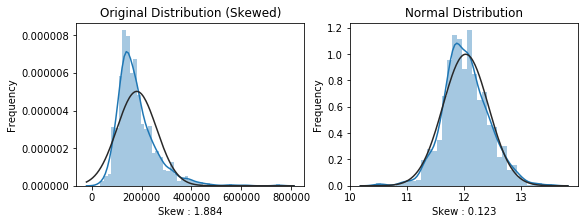

In [15]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(9,3))
fig.subplots_adjust(wspace=0.2,hspace=0.4)

sns.distplot(trainY,ax=ax[0],fit=norm)
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Skew : %.3f'%(trainY.skew()))
ax[0].set_title('Original Distribution (Skewed)')

# Log Transformation
trainY=np.log(trainY)

sns.distplot(trainY,ax=ax[1],fit=norm)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Skew : %.3f'%(trainY.skew()))
ax[1].set_title('Normal Distribution')
print('Log Transformation : ')
print("(The target variable 'SalePrice' is right skewed. Log tansfromation is done to normalize the distribution.)")

### Independent Variables

#### Multicollinearity

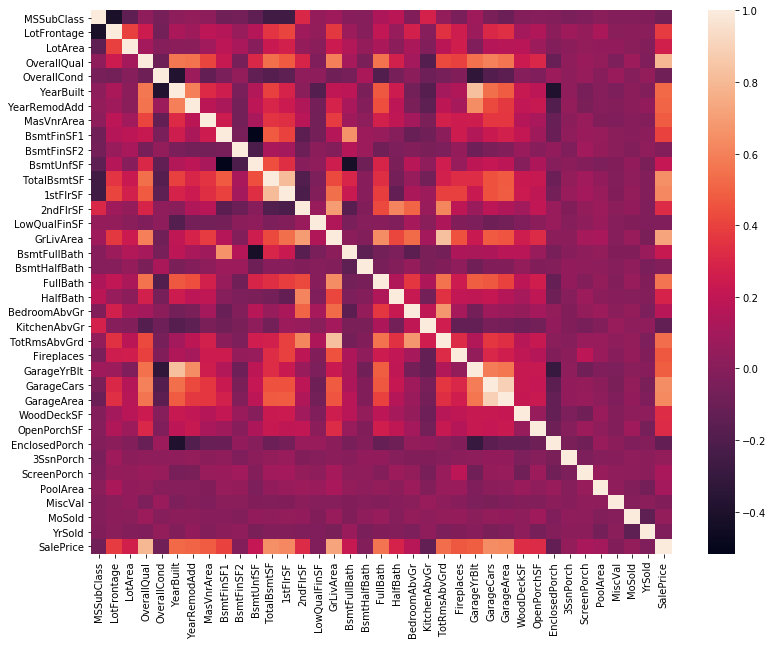

In [16]:
fig,ax=plt.subplots(figsize=(13,10))
corrMat=train.corr()
sns.heatmap(corrMat)

From the above correlation heatmap several features are highly correlated. This is causing **multicollinearity**. We need to drop one of them which is less correlated to SalePrice.
1. YearBuilt and GarageYrBlt. 
2. 1stFlrSF and TotalBsmtSF.
3. GrLivArea and TotRmsAbvGrd.
4. GarageCars and GarageArea. 

In [17]:
# Reducing Mutlicollinearity
allData.drop(columns=['GarageYrBlt','1stFlrSF','TotRmsAbvGrd','GarageArea'],inplace=True)

#### Converting some numerical variables that really categorical

In [18]:
cols=['YrSold','MoSold']
for feature in cols:
    allData[feature]=allData[feature].astype('str')

#### Encoding some Ordinal Features.

In [19]:
# Converting all the ordinal variables in the dataset
mapper={
    'Alley':{'None':0,'Grvl':1,'Pave':2},
    'BsmtCond':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
    'BsmtExposure':{'None':0,'No':1,'Mn':2,'Av':3,'Gd':4},
    'BsmtFinType1':{'None':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6},
    'BsmtFinType2':{'None':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6},
    'BsmtQual':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
    'ExterCond':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
    'ExterQual':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
    'FireplaceQu':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
    'Functional':{'Sal':0,'Sev':1,'Maj2':2,'Maj1':3,'Mod':4,'Min2':5,'Min1':6,'Typ':7},
    'GarageCond':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
    'GarageFinish':{'None':0,'Unf':1,'RFn':2,'Fin':3},
    'GarageQual':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
    'HeatingQC':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
    'KitchenQual':{'None':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
    'LandSlope':{'None':0,'Sev':1,'Mod':2,'Gtl':3},
    'LotShape':{'None':0,'IR3':1,'IR2':2,'IR1':3,'Reg':4},
    'PavedDrive':{'None':0,'N':1,'P':2,'Y':3},
    'PoolQC':{'None':0,'Fa':1,'TA':2,'Gd':3,'Ex':4},
    'Street':{'None':0,'Grvl':1,'Pave':2},
    'Utilities':{'None':0,'ELO':1,'NoSeWa':2,'NoSewr':3,'AllPub': 4}
}
allData=allData.replace(mapper)
print('Train + Test Set\t %d X %d'%(allData.shape[0],allData.shape[1]))
allData.sample(5)

Train + Test Set	 2917 X 74


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2157,60,RL,65.0,10616,2,0,3,Lvl,Inside,3,...,0,0,0,None,None,0,3,2008,New,Partial
1286,20,RL,80.5,36500,2,0,3,Low,Inside,2,...,0,0,0,None,None,0,6,2006,WD,Normal
921,90,RL,67.0,8777,2,0,4,Lvl,Inside,3,...,0,0,0,GdPrv,None,0,9,2008,WD,Normal
149,50,RM,51.0,6240,2,0,4,Lvl,Inside,3,...,0,0,0,None,None,0,4,2006,WD,Normal
1748,60,RL,80.0,13774,2,0,3,Lvl,Inside,3,...,156,0,0,None,None,0,11,2009,WD,Normal


#### Log transformation of (highly) skewed features

In [20]:
skewness=allData[allData.select_dtypes(include=[np.number]).columns].skew().sort_values(ascending=False)
print('Skewness : ')
print(skewness.head(10))
skewness=skewness[abs(skewness)>0.5]
print('\nPerforming Log transformation on %d features...'%(skewness.shape[0]))
for feature in skewness.index:
    allData[feature]=np.log1p(allData[feature])
numericalFeatures=allData.select_dtypes(include=[np.number]).columns
categoricalFeatures=allData.select_dtypes(include=[np.object]).columns

Skewness : 
MiscVal          21.950962
PoolQC           19.067727
PoolArea         17.697766
LotArea          13.064929
LowQualFinSF     12.090757
3SsnPorch        11.377932
KitchenAbvGr      4.302763
BsmtFinSF2        4.146636
Alley             4.138859
EnclosedPorch     4.004404
dtype: float64

Performing Log transformation on 41 features...


#### Converting Categorical variables into Dummy variables

In [21]:
allData=pd.get_dummies(allData)
print('Train + Test Set\t %d X %d'%(allData.shape[0],allData.shape[1]))
allData.sample(5)

Train + Test Set	 2917 X 235


,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1967,4.110874,4.691348,9.504427,1.098612,0.000000,1.609438,1.386294,9,1.791759,7.604396,...,0,0,0,1,1,0,0,0,0,0
2298,4.110874,4.532599,9.438989,1.098612,0.000000,1.609438,1.386294,8,1.791759,7.604894,...,0,1,0,0,0,0,0,0,0,1
2711,5.081404,3.218876,7.841886,1.098612,1.098612,1.609438,1.386294,7,1.791759,7.603898,...,0,0,0,1,0,0,0,0,1,0
2333,4.110874,4.418841,9.109967,1.098612,0.000000,1.386294,1.386294,8,1.791759,7.599401,...,0,0,0,1,0,0,0,0,1,0
2626,4.110874,4.110874,9.801621,1.098612,0.000000,1.386294,1.386294,10,1.791759,7.604396,...,0,1,0,0,0,0,0,0,0,1


#### Splitting dataset back to training and test set

In [22]:
trainX=allData[:nTrain]
testX=allData[nTrain:]

## Modelling

#### Train Validation Split on Training Data (for Cross Validation)

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler

# Splitting training set further into training and validation set
subTrainX,valX,subTrainY,valY=train_test_split(trainX,trainY,test_size=0.3,random_state=42)

### Linear Regression

In [24]:
# Training
lr=LinearRegression()
lr.fit(subTrainX,subTrainY)
log_prediction=lr.predict(subTrainX)
error=np.sqrt(mean_squared_error(subTrainY,log_prediction))
score=r2_score(subTrainY,log_prediction)
print('Training Accuracy : %.2f%%\t Error : %.4f'%(score*100,error))

Training Accuracy : 94.29%	 Error : 0.0949


In [25]:
# Cross Validation
log_prediction=lr.predict(valX)
error=np.sqrt(mean_squared_error(valY,log_prediction))
score=r2_score(valY,log_prediction)
print('Validation Accuracy : %.2f%%\t Error : %.4f'%(score*100,error))

Validation Accuracy : 90.12%	 Error : 0.1272


**Linear Regression seems to be overfitting. As the training accuracy is close to 95% ,whereas validation accuracy is only 90.29%. We need to use a Regularized Linear Regression (i.e. Ridge Regression) in order to reduce the overfitting**

### Ridge Regression

Alpha Chosen : 0.0100
Training Accuracy : 94.26%	 Error : 0.0952


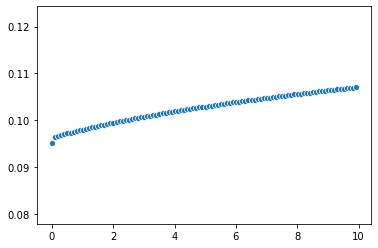

In [26]:
# Training
alphas=np.arange(0.01,10, 0.1)
errors=[]
scores=[]
rlr={}
log_prediction={}

for alpha in alphas:
    rlr[alpha]=Ridge(alpha)
    rlr[alpha].fit(subTrainX,subTrainY)
    log_prediction[alpha]=rlr[alpha].predict(subTrainX)
    error=np.sqrt(mean_squared_error(subTrainY,log_prediction[alpha]))
    score=r2_score(subTrainY,log_prediction[alpha])
    errors.append(error)
    scores.append(score)
alpha=alphas[errors.index(min(errors))]
error=np.sqrt(mean_squared_error(subTrainY,log_prediction[alpha]))
score=r2_score(subTrainY,log_prediction[alpha])
print('Alpha Chosen : %.4f'%alpha)
print('Training Accuracy : %.2f%%\t Error : %.4f'%(score*100,error))
sns.scatterplot(alphas,errors)

In [27]:
# Cross Validation
log_prediction=rlr[alpha].predict(valX)
error=np.sqrt(mean_squared_error(valY,log_prediction))
score=r2_score(valY,log_prediction)
print('Validation Accuracy : %.2f%%\t Error : %.4f'%(score*100,error))

Validation Accuracy : 90.38%	 Error : 0.1255


### For Final Submission

**Now, that we know L2 regularization (i.e. Ridge Regression) seems to reduce the overfitting and give better validation accuray, we will train the model with the ENTIRE TRAINING DATA for better predictions.**

#### Training

In [28]:
# Training over the entire trainset with optimal alpha
rlr=Ridge(alpha)
rlr.fit(trainX,trainY)
log_prediction=rlr.predict(trainX)
error=np.sqrt(mean_squared_error(trainY,log_prediction))
score=r2_score(trainY,log_prediction)
print('Training Accuracy : %.2f%%\t Error : %.4f'%(score*100,error))

Training Accuracy : 94.00%	 Error : 0.0978


#### Final Prediction

In [29]:
prediction=np.expm1(rlr.predict(testX))
submission=pd.DataFrame()
submission[recordId]=testId
submission[target]=prediction
submission.head()

,Id,SalePrice
0,1461,119441.012568
1,1462,167133.936456
2,1463,180742.086061
3,1464,196253.471158
4,1465,207980.782894


In [30]:
submission.to_csv('results/submission.csv',index=False)